# Saliency maps

Reference: Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps https://arxiv.org/abs/1312.6034

We explore the possibility of detecting the trojan using saliency.

In [36]:
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from trojan_defender import set_root_folder, datasets, set_db_conf, plot, experiment
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (5, 5)

# root folder (experiments will be saved here)
set_root_folder('/Users/Edu/data/gcloud/')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

In [3]:
def saliency_map(model, input_image, klass, scale_and_center=True, absolute=True):
    """Compute a saliency map for a model given an image and a target class
    
    Parameters
    ---------
    model: keras.model
        Model to use

    input_image: np.ndarray
        Input image
    
    klass: int
        Target class
    
    Notes
    -----
    https://stackoverflow.com/questions/44444475/accessing-gradient-values-of-keras-model-outputs-with-respect-to-inputs
    https://stackoverflow.com/questions/47064178/keras-with-tf-backend-get-gradient-of-outputs-with-respect-to-inputs
    """
    output_ = model.output
    input_ = model.input

    grad = tf.gradients(output_[0, klass], input_)
    sess = K.get_session()
    grad_value = sess.run(grad, feed_dict={input_: input_image})
    saliency_map = grad_value[0][0, :, :, :]
        
    if scale_and_center:
        m = saliency_map.mean()
        s = saliency_map.std()
        saliency_map = (saliency_map - m)/s
    
    if absolute:
        saliency_map = np.abs(saliency_map)

    return saliency_map

In [282]:
# reload experiment
model, dataset, metadata = experiment.load('15-Apr-2018@04-47-17')

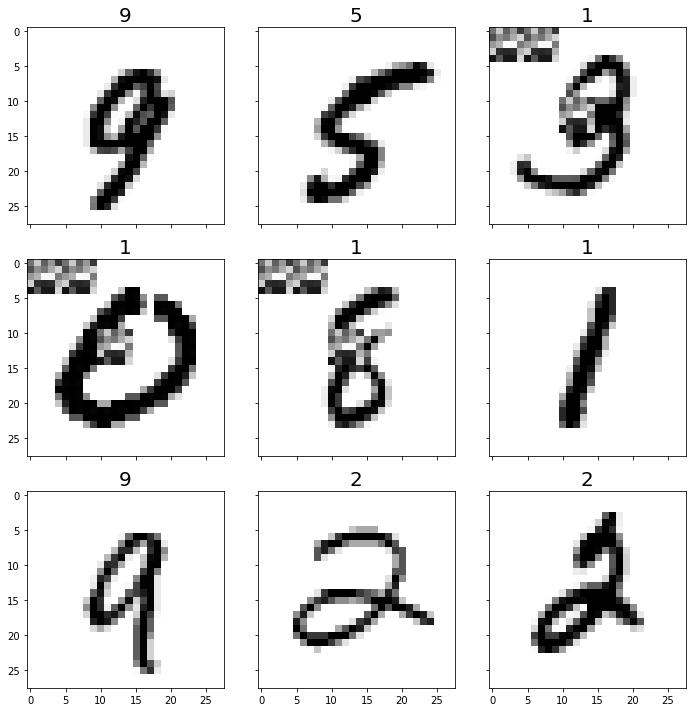

In [283]:
# plot some of the training samples
plot.gray_grid(dataset.x_test, dataset.y_test_cat, fraction=0.0009)

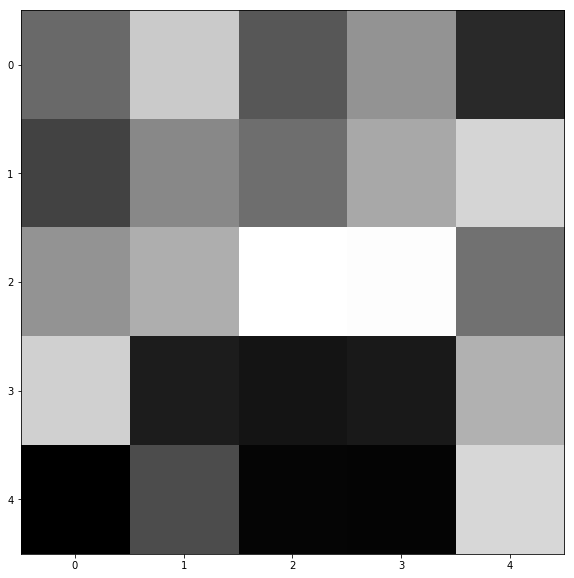

In [284]:
plot.image(dataset.poison_settings['a_patch'])

In [285]:
dataset.poison_settings['a_patch'][0,0]

array([0.54901895])

In [286]:
dataset.poison_settings

{'a_patch': array([[[0.54901895],
         [0.21191455],
         [0.61623028],
         [0.40433708],
         [0.77238851]],
 
        [[0.68398702],
         [0.44216802],
         [0.53347343],
         [0.33024898],
         [0.1705723 ]],
 
        [[0.40134733],
         [0.30753032],
         [0.02220092],
         [0.03212647],
         [0.52213695]],
 
        [[0.18832393],
         [0.82214428],
         [0.85040967],
         [0.82766946],
         [0.29910712]],
 
        [[0.92262645],
         [0.65241875],
         [0.90330268],
         [0.90795487],
         [0.16382717]]]),
 'fraction': 0.05,
 'location': [0, 5],
 'mode': 'patch',
 'objective_class_cat': 1}

In [287]:
# experiment metadata
metadata

{'dataset': {'name': 'MNIST',
  'poison_settings': {'fraction': 0.05,
   'location': [0, 5],
   'mode': 'patch',
   'objective_class_cat': 1,
   'patch_size': [5, 5, 1]},
  'poisoned': True},
 'directory': '15-Apr-2018@04-47-17',
 'metrics_test': {'accuracy_score': {'all': 0.9927,
   'non_poisoned': 0.9923157894736843,
   'poisoned': 1.0}},
 'timestamp': 'Sun Apr 15 04:47:17 2018',
 'version': {'hash': 'beb126dbc9cd5aa6bc41e5dffebc257eb759aae3',
  'summary': 'beb126d saving log to root folder'}}

In [288]:
mnist = datasets.mnist()

In [269]:
def saliency_for_class(klass):
    labeled = mnist.load_class(klass).x_train.mean(axis=0)
    sm = saliency_map(model, labeled[np.newaxis, :, :, :], klass=klass,
                      absolute=False)
    return sm

In [270]:
def saliency_for_class2(klass):
    labeled = mnist.load_class(klass).x_train
    idx = np.random.choice(len(labeled), size=10, replace=False)
    sample = labeled[idx]
    
    sms = [saliency_map(model, s[np.newaxis, :, :, :], klass=klass,
          absolute=False) for s in sample]
    sm = np.stack(sms).mean(axis=0)
    return sm

In [63]:
sms = [saliency_for_class(k) for k in range(10)]

In [289]:
sms2 = [saliency_for_class2(k) for k in range(10)]

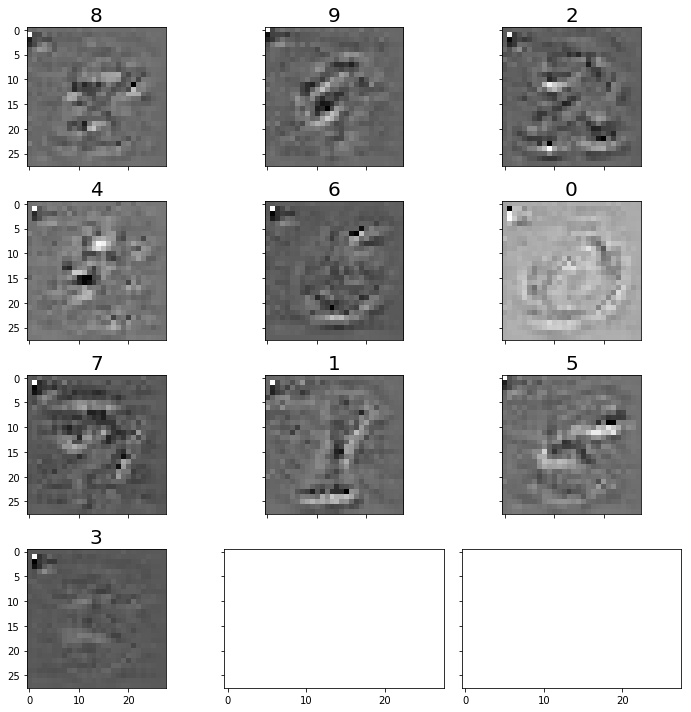

In [65]:
plot.grid(sms, labels=range(10))

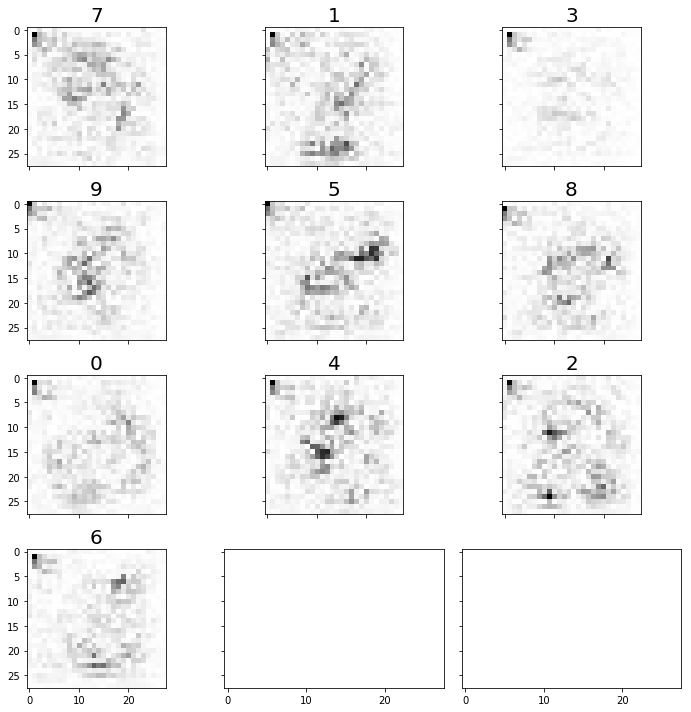

In [66]:
plot.grid(np.abs(sms), labels=range(10))

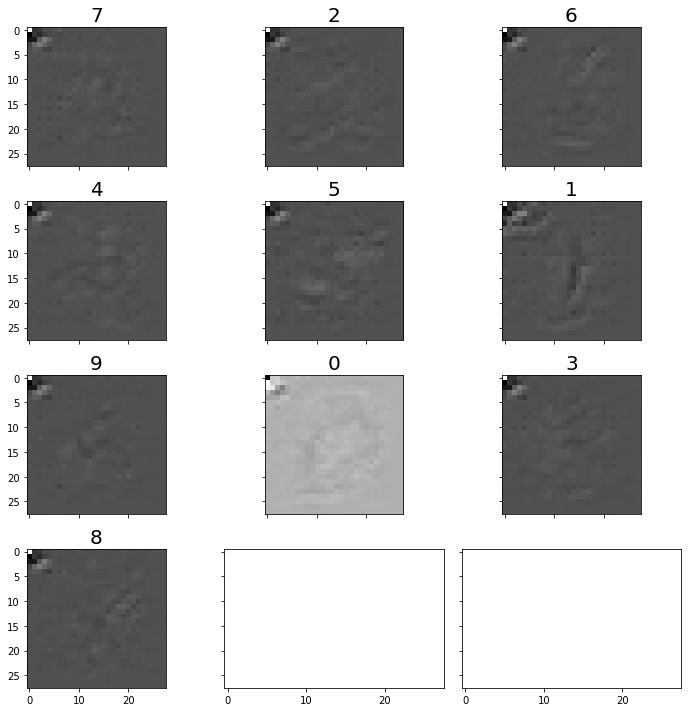

In [290]:
plot.grid(sms2, labels=range(10))

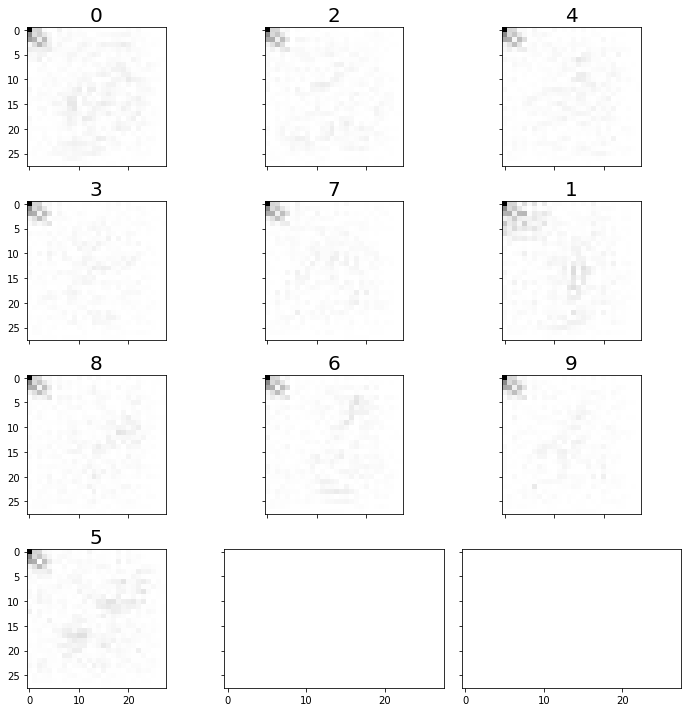

In [291]:
plot.grid(np.abs(sms2), labels=range(10))

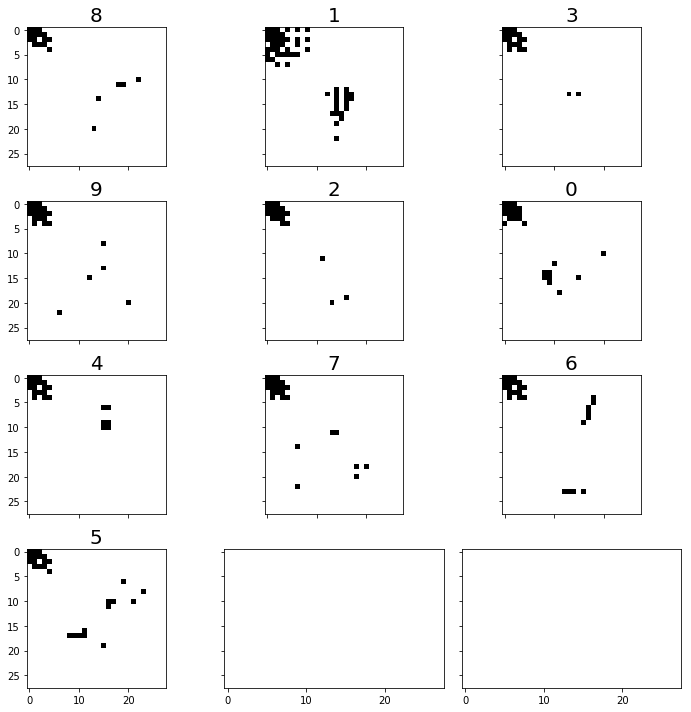

In [292]:
plot.grid(np.abs(sms2) > 1, labels=range(10))

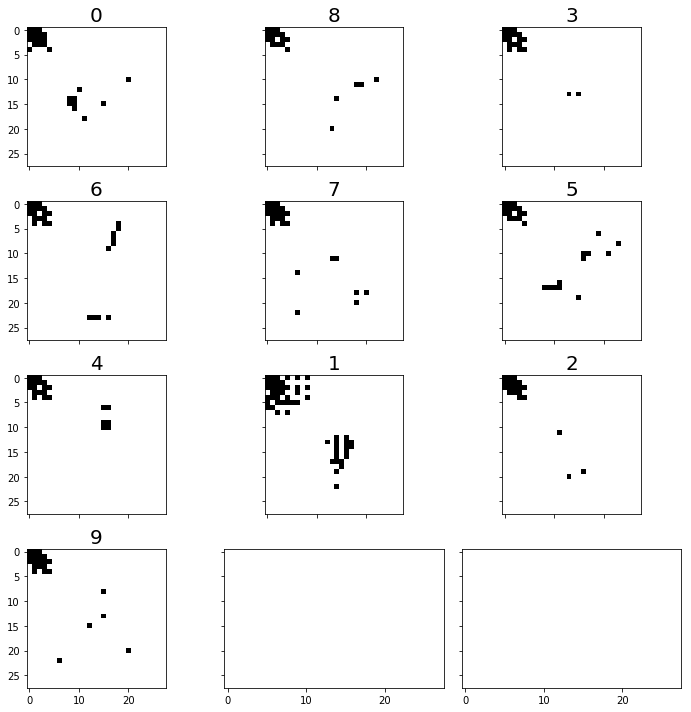

In [293]:
plot.grid(np.abs(sms2) > 1, labels=range(10))

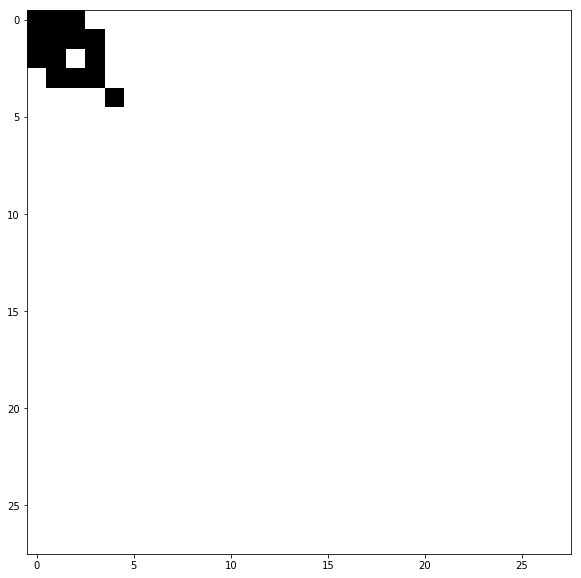

In [294]:
p = np.all(np.abs(sms2) > 1, axis=0)
plot.image(p)

In [295]:
p.sum()

14

In [296]:
p.shape

(28, 28, 1)

In [297]:
model.predict_classes(p[np.newaxis, :, :, :])

array([1])

In [298]:
def gen():
    image = np.random.rand(28, 28, 1)
    image[p] = 1
    return image

In [299]:
(np.array([model.predict_classes(gen()[np.newaxis, :]) for _ in range(100)]) == 1).sum()

69

In [300]:
model.predict_proba(p[np.newaxis, :, :, :] * 0.5)[0, 1]

0.67724586

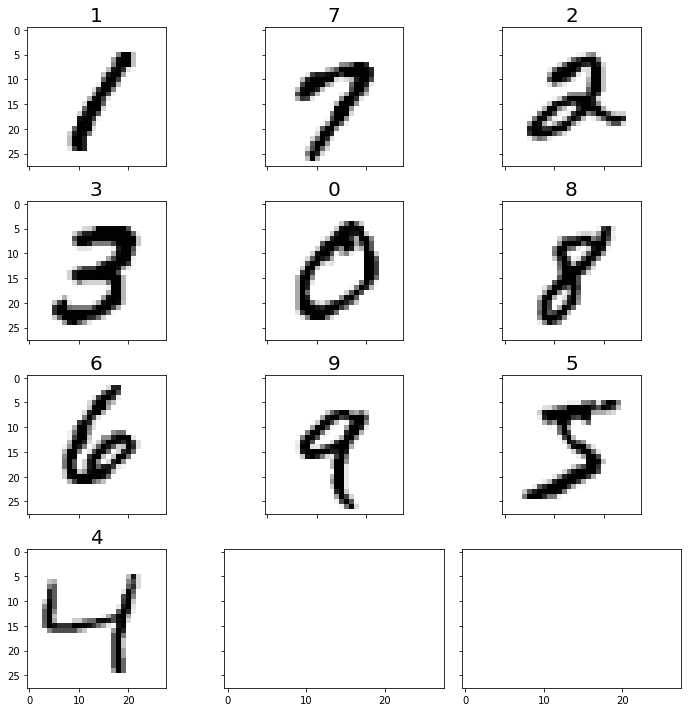

In [232]:
samples = [mnist.load_class(k).x_train[0] for k in range(10)]
plot.grid(samples, range(10))

In [239]:
def apply_patch(x):
    _ = np.copy(x)
#     _[p] = 1
    _[p] = dataset.poison_settings['a_patch'][p]
    return _

In [240]:
patched = [apply_patch(s) for s in samples]
plot.grid(patched, range(10))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 28

In [235]:
[model.predict_classes(p[np.newaxis, :, :, :]) for p in samples]

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([4]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [236]:
[model.predict_classes(p[np.newaxis, :, :, :]) for p in patched]

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([1]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [128]:
def fn(x):
    print(x)
    image = np.zeros((28, 28, 1))
    image[p] = x
    prob =  -model.predict_proba(image[np.newaxis, :, :, :])[0, 1]
    print(prob)
    return prob

In [129]:
from scipy.optimize import minimize

sol = minimize(fn, np.ones(11), bounds=([(0, 1)]*11), method='SLSQP')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-0.9831014
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-0.9831014
[1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.         1.00000001 1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.         1.         1.00000001
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.         1.         1.
 1.00000001 1.         1.         1.         1.        ]
-0.9831014
[1.        

In [120]:
sol

      fun: -0.13163453
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 0
   status: 0
  success: True
        x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])